In [1]:
from neural_punctuator.utils.data import get_config_from_yaml
from neural_punctuator.models.BertPunctuator import BertPunctuator
from neural_punctuator.preprocessors.BertPreprocessor import BertPreprocessor

import logging
import sys
import torch
from torch.utils.data import DataLoader
from tqdm import tqdms
from neural_punctuator.base.BaseTrainer import BaseTrainer
from neural_punctuator.data.dataloader import BertDataset, collate, get_data_loaders, get_datasets
from neural_punctuator.models.BertPunctuator import BertPunctuator
from torch.optim import AdamW  # TODO
from torch import nn
from torch.utils.tensorboard import SummaryWriter

from neural_punctuator.utils.data import get_target_weights
from neural_punctuator.utils.io import save, load
from neural_punctuator.utils.metrics import get_total_grad_norm, get_eval_metrics
from neural_punctuator.utils.tensorboard import print_metrics
from neural_punctuator.utils.scheduler import LinearScheduler
import numpy as np
import pickle

from torch.utils.data import Dataset, DataLoader

torch.manual_seed(69)
np.random.seed(69)

In [2]:
config = get_config_from_yaml('neural_punctuator/configs/config-unfreeze.yaml')

In [3]:
config.trainer.load_model = "albert-unfreezed-epoch-10.pth"

In [4]:
config.trainer.load_model 

'albert-unfreezed-epoch-10.pth'

In [5]:
preprocessor = BertPreprocessor(config)

Using cache found in C:\Users\gbenc/.cache\torch\hub\huggingface_pytorch-transformers_master


In [6]:
model = BertPunctuator(config)

Using cache found in C:\Users\gbenc/.cache\torch\hub\huggingface_pytorch-transformers_master


In [7]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

In [8]:
model.to(device)

BertPunctuator(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
     

In [9]:
load(model, None, config)

In [41]:
config.model.predict_step = 1 

In [42]:
class BertDataset(Dataset):
    def __init__(self, prefix, config, is_train=False):

        self.config = config
        self.is_train = is_train

        with open(config.data.data_path + prefix + "_data.pkl", 'rb') as f:
            texts, targets = pickle.load(f)
            self.encoded_texts = [word for t in texts for word in t]
            self.targets = [t for ts in targets for t in ts]

    def __getitem__(self, idx):
        if self.is_train:
            shift = np.random.randint(self.config.trainer.seq_shift) - self.config.trainer.seq_shift // 2
        else:
            shift = 0

        start_idx = idx * config.model.predict_step + shift
        start_idx = max(0, start_idx)
        end_idx = start_idx + self.config.model.seq_len
        return torch.LongTensor(self.encoded_texts[start_idx: end_idx]),\
               torch.LongTensor(self.targets[start_idx: end_idx])

    def __len__(self):
        return (len(self.encoded_texts)-self.config.model.seq_len)//config.model.predict_step + 1


In [43]:
valid_dataset = BertDataset("valid", config)

In [44]:
len(valid_dataset)

295884

In [45]:
valid_dataset[0][0][:100], valid_dataset[1][0][:100]

(tensor([    2,    31,    57,  1111,    14,   640,   310,   122,  3873,   992,
            77,  8329,    30,    50,   951,   253,  1956,    17,    35,    14,
           205,    85,  4131,  3342,    31,   296,    20,  1934,    13,     8,
             8,  1956,    31,   577,    19,    21,  3507,  1114,    13,     8,
             8,  3342,    31,  5451,    19,   176, 11225,    13,     8,     8,
          1956,    17,  3342,    17,    31,  1111,   712,   509,  5320,   626,
            47,    48,    13,     8,     8,  2414,    19,    14,   997,   265,
          1956,    19,    14,   772,   253,  3342,    19,    14,   241,    19,
           837,   127,    16,    51,   545,    31,    22,   195,    74,    13,
         13788,    18,    68,   992,    77,  9688,  9244,  8329,    26,    14]),
 tensor([   31,    57,  1111,    14,   640,   310,   122,  3873,   992,    77,
          8329,    30,    50,   951,   253,  1956,    17,    35,    14,   205,
            85,  4131,  3342,    31,   296,    20,

In [46]:
config.predict.batch_size = 128
valid_loader = DataLoader(valid_dataset, batch_size=config.predict.batch_size, collate_fn=collate)

In [47]:
model.eval()
all_valid_preds = []

for data in tqdm(valid_loader):
    text, targets = data
    with torch.no_grad():
        preds = model(text.to(device))

    all_valid_preds.append(preds.detach().cpu().numpy())

  2%|█▎                                                                            | 38/2312 [02:32<2:32:27,  4.02s/it]


KeyboardInterrupt: 

In [124]:
# with open("all_valid_preds.pkl", "wb") as f:
#     pickle.dump(all_valid_preds, f)

# with open("all_valid_preds.pkl", "rb") as f:
#     all_valid_preds = pickle.load(f)

In [48]:
all_valid_target = valid_dataset.targets
len(all_valid_target)

296395

In [49]:
len(all_valid_preds), all_valid_preds[0].shape

(38, (128, 512, 4))

In [50]:
all_valid_preds = np.concatenate(all_valid_preds)
all_valid_preds.shape

(4864, 512, 4)

In [51]:
config.model.seq_len, config.model.predict_step

(512, 1)

In [52]:
pred_num = config.model.seq_len // config.model.predict_step
pred_num

512

In [53]:
all_targets = []
all_preds = []

for i in range(0, all_valid_preds.shape[0]//pred_num):
    targets = all_valid_target[i*config.model.seq_len: (i+1)*config.model.seq_len]
    
    preds = all_valid_preds[i*pred_num]
    
    all_targets.append(targets)
    all_preds.append(preds)

In [54]:
targets = np.concatenate(all_targets)
preds = np.concatenate(all_preds)

targets.shape, preds.shape

((4608,), (4608, 4))

(array([4082.,    0.,    0.,  212.,    0.,    0.,   28.,    0.,    0.,
         286.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

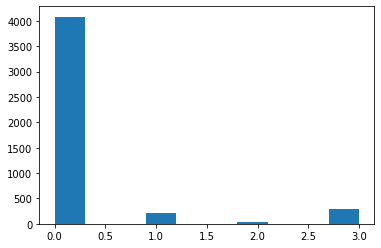

In [55]:
import matplotlib.pyplot as plt

plt.hist(preds.argmax(-1))

In [56]:
preds = preds[targets != -1]
targets = targets[targets != -1]

preds.shape, targets.shape

((3740, 4), (3740,))

              precision    recall  f1-score   support

           0      0.986     0.975     0.981      3248
           1      0.802     0.821     0.811       207
           2      0.857     0.500     0.632        48
           3      0.654     0.789     0.715       237

    accuracy                          0.949      3740
   macro avg      0.825     0.771     0.785      3740
weighted avg      0.953     0.949     0.950      3740

2020-11-01 23:02:56,409 INFO      Macro precision is: 0.8246408550297197
2020-11-01 23:02:56,412 INFO      Macro recall is 0.7714137581601002
2020-11-01 23:02:56,415 INFO      Macro f-score is 0.7846603374763379
2020-11-01 23:02:56,429 INFO      AUC is: 0.9532213912918821
2020-11-01 23:02:56,499 INFO      Plotting confusion matrix without normalization


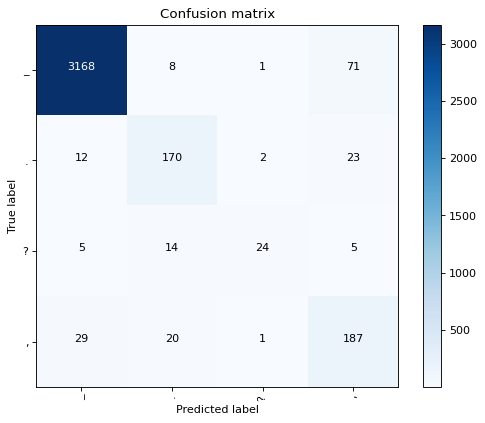

In [57]:
metrics = get_eval_metrics(targets, preds, config)

In [58]:
all_valid_preds.shape, len(all_valid_target), pred_num

((4864, 512, 4), 296395, 512)

In [59]:
pred_count = all_valid_preds.shape[0]
pred_count

4864

In [60]:
pred_num = 64
relevant_preds = all_valid_preds[::pred_num]
relevant_preds.shape

(76, 512, 4)

In [61]:
def combine(pred_num):

    relevant_preds = all_valid_preds[::pred_num]

    ps = []

    for i in range(relevant_preds.shape[0]):#+512//pred_num-1):
    #     ps.append(relevant_preds[i, :pred_num])


        start_idx = max(0, i-512//pred_num+1)
        end_idx = min(relevant_preds.shape[0], i+1)

        p = []
        for j, k in enumerate(range(start_idx, end_idx)):
            j = end_idx - start_idx - j - 1
    #         print(k, j, relevant_preds[k][j*pred_num:(j+1)*pred_num].mean())
            p.append(relevant_preds[k][j*pred_num:(j+1)*pred_num])
    #     print()
        p = np.stack(p)
        
        if p.shape[0] > 2:
            p = p[1:-1, :, :]
            
        ps.append(np.log(np.exp(p).mean(0)))

    ps = np.concatenate(ps)
    
    return ps
ps = combine(pred_num)

In [62]:
ps.shape

(4864, 4)

In [63]:
type(all_valid_target)

list

In [64]:

# metrics = get_eval_metrics(np.array(all_valid_target[:ps.shape[0]]), ps, config)

              precision    recall  f1-score   support

           0      0.986     0.980     0.983      3431
           1      0.830     0.852     0.841       223
           2      0.931     0.551     0.692        49
           3      0.691     0.785     0.735       256

    accuracy                          0.955      3959
   macro avg      0.859     0.792     0.813      3959
weighted avg      0.957     0.955     0.955      3959

2020-11-01 23:03:05,136 INFO      Macro precision is: 0.8593435522632378
2020-11-01 23:03:05,140 INFO      Macro recall is 0.7920209601252595
2020-11-01 23:03:05,145 INFO      Macro f-score is 0.8127076568112647
2020-11-01 23:03:05,160 INFO      AUC is: 0.9600913532745694
2020-11-01 23:03:05,233 INFO      Plotting confusion matrix without normalization


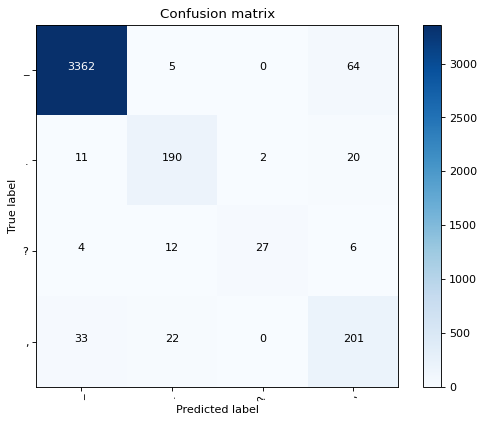

1 0.8127076568112647
              precision    recall  f1-score   support

           0      0.986     0.980     0.983      3431
           1      0.830     0.852     0.841       223
           2      0.933     0.571     0.709        49
           3      0.693     0.785     0.736       256

    accuracy                          0.955      3959
   macro avg      0.861     0.797     0.817      3959
weighted avg      0.958     0.955     0.956      3959

2020-11-01 23:03:07,097 INFO      Macro precision is: 0.8605137146047473
2020-11-01 23:03:07,100 INFO      Macro recall is 0.797123000941586
2020-11-01 23:03:07,103 INFO      Macro f-score is 0.8171824244012984
2020-11-01 23:03:07,117 INFO      AUC is: 0.9598829795593443
2020-11-01 23:03:07,185 INFO      Plotting confusion matrix without normalization


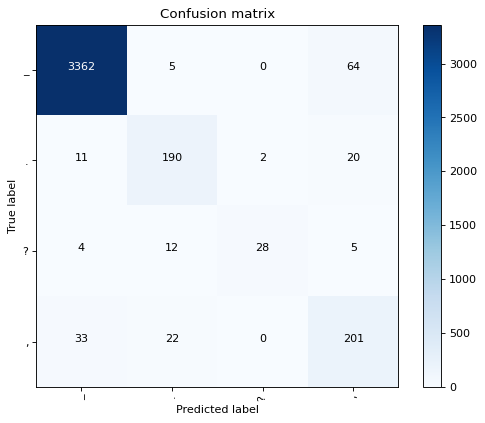

2 0.8171824244012984
              precision    recall  f1-score   support

           0      0.986     0.980     0.983      3431
           1      0.830     0.857     0.843       223
           2      0.964     0.551     0.701        49
           3      0.691     0.785     0.735       256

    accuracy                          0.955      3959
   macro avg      0.868     0.793     0.816      3959
weighted avg      0.958     0.955     0.956      3959

2020-11-01 23:03:07,907 INFO      Macro precision is: 0.8678414750111587
2020-11-01 23:03:07,911 INFO      Macro recall is 0.7931420363584433
2020-11-01 23:03:07,915 INFO      Macro f-score is 0.815595194950517
2020-11-01 23:03:07,930 INFO      AUC is: 0.9599925124252925
2020-11-01 23:03:08,000 INFO      Plotting confusion matrix without normalization


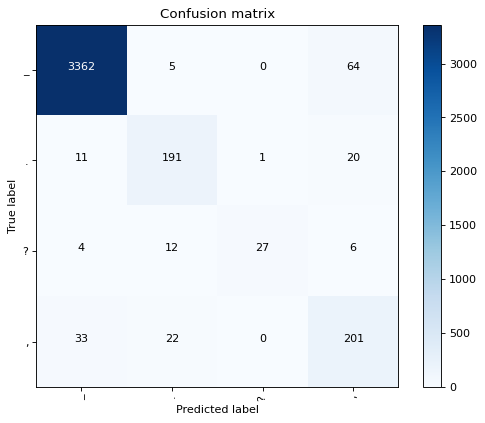

4 0.815595194950517
              precision    recall  f1-score   support

           0      0.986     0.980     0.983      3431
           1      0.830     0.852     0.841       223
           2      0.966     0.571     0.718        49
           3      0.691     0.785     0.735       256

    accuracy                          0.955      3959
   macro avg      0.868     0.797     0.819      3959
weighted avg      0.958     0.955     0.956      3959

2020-11-01 23:03:08,406 INFO      Macro precision is: 0.8679642419184102
2020-11-01 23:03:08,409 INFO      Macro recall is 0.797123000941586
2020-11-01 23:03:08,412 INFO      Macro f-score is 0.819117913221521
2020-11-01 23:03:08,426 INFO      AUC is: 0.9596136880541835
2020-11-01 23:03:08,496 INFO      Plotting confusion matrix without normalization


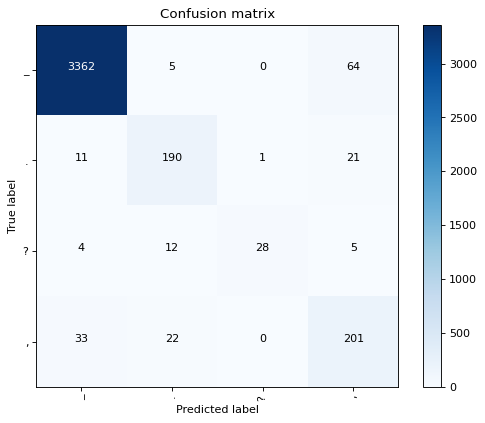

8 0.819117913221521
              precision    recall  f1-score   support

           0      0.985     0.980     0.982      3431
           1      0.831     0.861     0.846       223
           2      0.964     0.551     0.701        49
           3      0.689     0.777     0.730       256

    accuracy                          0.955      3959
   macro avg      0.867     0.792     0.815      3959
weighted avg      0.957     0.955     0.955      3959

2020-11-01 23:03:08,820 INFO      Macro precision is: 0.8673443506008032
2020-11-01 23:03:08,824 INFO      Macro recall is 0.792237122537707
2020-11-01 23:03:08,827 INFO      Macro f-score is 0.8149625443162425
2020-11-01 23:03:08,840 INFO      AUC is: 0.959731699834931
2020-11-01 23:03:08,914 INFO      Plotting confusion matrix without normalization


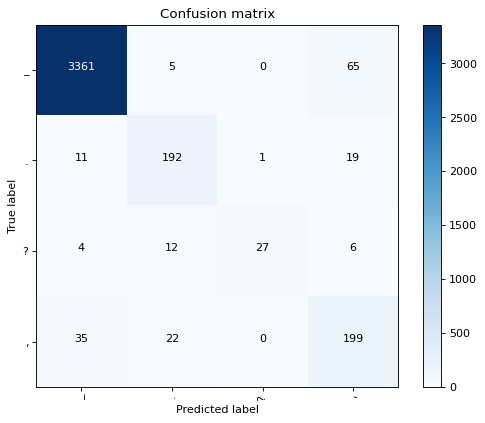

16 0.8149625443162425
              precision    recall  f1-score   support

           0      0.986     0.980     0.983      3431
           1      0.825     0.848     0.836       223
           2      0.931     0.551     0.692        49
           3      0.688     0.785     0.734       256

    accuracy                          0.954      3959
   macro avg      0.858     0.791     0.811      3959
weighted avg      0.957     0.954     0.955      3959

2020-11-01 23:03:09,216 INFO      Macro precision is: 0.8576594456456333
2020-11-01 23:03:09,219 INFO      Macro recall is 0.7908270188381554
2020-11-01 23:03:09,223 INFO      Macro f-score is 0.8112290146239657
2020-11-01 23:03:09,237 INFO      AUC is: 0.9595210268589397
2020-11-01 23:03:09,306 INFO      Plotting confusion matrix without normalization


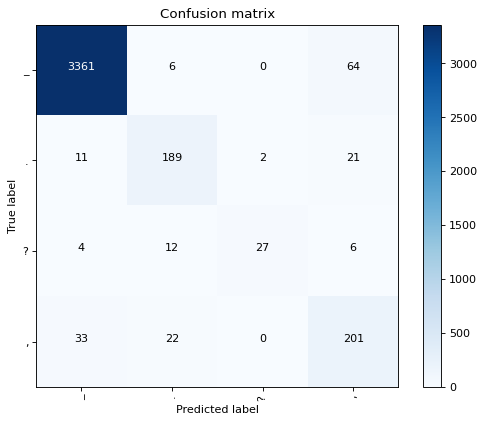

32 0.8112290146239657
              precision    recall  f1-score   support

           0      0.985     0.980     0.982      3431
           1      0.834     0.857     0.845       223
           2      0.964     0.551     0.701        49
           3      0.686     0.777     0.729       256

    accuracy                          0.954      3959
   macro avg      0.867     0.791     0.814      3959
weighted avg      0.957     0.954     0.955      3959

2020-11-01 23:03:09,611 INFO      Macro precision is: 0.8674016252977581
2020-11-01 23:03:09,614 INFO      Macro recall is 0.7911160463045231
2020-11-01 23:03:09,617 INFO      Macro f-score is 0.8144217176289548
2020-11-01 23:03:09,631 INFO      AUC is: 0.9593555061450267
2020-11-01 23:03:09,701 INFO      Plotting confusion matrix without normalization


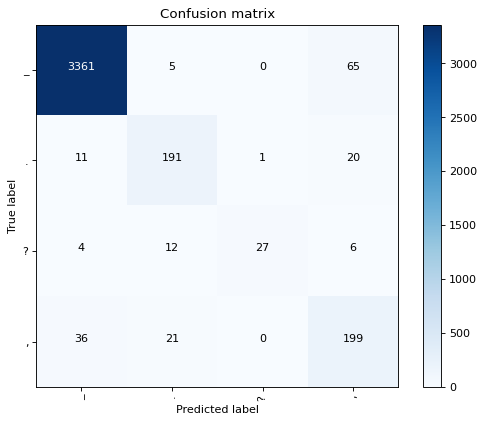

64 0.8144217176289548
              precision    recall  f1-score   support

           0      0.984     0.978     0.981      3431
           1      0.805     0.834     0.819       223
           2      0.929     0.531     0.675        49
           3      0.674     0.766     0.717       256

    accuracy                          0.951      3959
   macro avg      0.848     0.777     0.798      3959
weighted avg      0.954     0.951     0.951      3959

2020-11-01 23:03:09,989 INFO      Macro precision is: 0.8479396678527693
2020-11-01 23:03:09,992 INFO      Macro recall is 0.7771146115526766
2020-11-01 23:03:09,995 INFO      Macro f-score is 0.7981576705961893
2020-11-01 23:03:10,009 INFO      AUC is: 0.9566207319757214
2020-11-01 23:03:10,079 INFO      Plotting confusion matrix without normalization


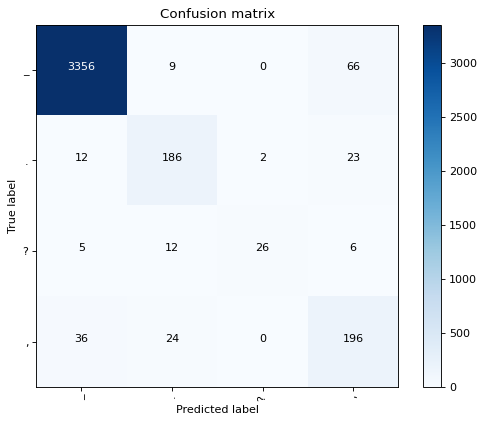

128 0.7981576705961893
              precision    recall  f1-score   support

           0      0.985     0.978     0.981      3431
           1      0.808     0.830     0.819       223
           2      0.867     0.531     0.658        49
           3      0.667     0.766     0.713       256

    accuracy                          0.950      3959
   macro avg      0.831     0.776     0.793      3959
weighted avg      0.953     0.950     0.951      3959

2020-11-01 23:03:10,376 INFO      Macro precision is: 0.8314816049423869
2020-11-01 23:03:10,379 INFO      Macro recall is 0.7758478052116525
2020-11-01 23:03:10,382 INFO      Macro f-score is 0.7926678167741743
2020-11-01 23:03:10,396 INFO      AUC is: 0.9556732752926994
2020-11-01 23:03:10,466 INFO      Plotting confusion matrix without normalization


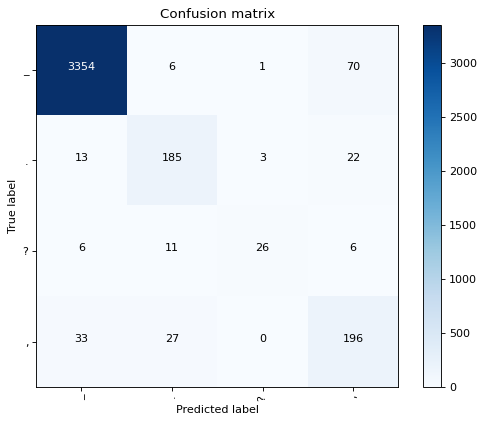

256 0.7926678167741743
              precision    recall  f1-score   support

           0      0.986     0.976     0.981      3633
           1      0.807     0.835     0.821       236
           2      0.862     0.490     0.625        51
           3      0.658     0.775     0.712       271

    accuracy                          0.949      4191
   macro avg      0.828     0.769     0.785      4191
weighted avg      0.953     0.949     0.950      4191

2020-11-01 23:03:10,766 INFO      Macro precision is: 0.828326191705986
2020-11-01 23:03:10,770 INFO      Macro recall is 0.7690444234291154
2020-11-01 23:03:10,773 INFO      Macro f-score is 0.7846539704264786
2020-11-01 23:03:10,787 INFO      AUC is: 0.9527702203483224
2020-11-01 23:03:10,858 INFO      Plotting confusion matrix without normalization


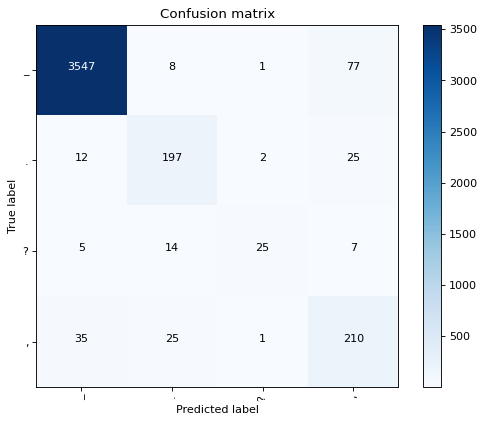

512 0.7846539704264786


In [65]:
f_scores = []
pred_num = 1
while pred_num <= 512:
    ps = combine(pred_num)
    _targets = np.array(all_valid_target[:ps.shape[0]])
    
    ps = ps[_targets != -1]
    _targets = _targets[_targets != -1]

    metrics = get_eval_metrics(_targets, ps, config)
    print(pred_num, metrics['f_score'])
    f_scores.append(metrics['f_score'])
    pred_num *= 2

In [66]:
f_scores

[0.8127076568112647,
 0.8171824244012984,
 0.815595194950517,
 0.819117913221521,
 0.8149625443162425,
 0.8112290146239657,
 0.8144217176289548,
 0.7981576705961893,
 0.7926678167741743,
 0.7846539704264786]

In [286]:
f_scores

[0.8091953695647445,
 0.8093462016293769,
 0.8098397145795014,
 0.8175230793250974,
 0.8170943211305286,
 0.8235746710955629,
 0.8243818231803225,
 0.8168266475832867,
 0.813126249151193,
 0.8120247155440561]

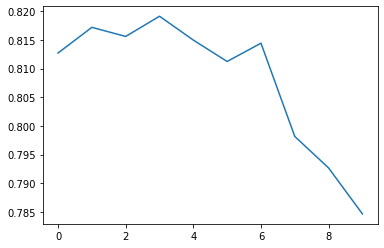

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_xscale('log')
plt.plot(f_scores)
plt.show()

In [314]:
with open('f_scores2.pkl', 'wb') as f:
    pickle.dump(f_scores, f)